# COSMOS master catalogue
## Preparation of DECam Legacy Survey data

This catalogue comes from `dmu0_DECaLS`.

In the catalogue, we keep:

- The `object_id` as unique object identifier;
- The position;
- The u, g, r, i, z, Y aperture magnitude (2”);
- The u, g, r, i, z, Y kron fluxes and magnitudes.

We check for all ugrizY then only take bands for which there are measurements

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
017bb1e (Mon Jun 18 14:58:59 2018 +0100)
This notebook was executed on: 
2019-01-23 13:14:28.824998


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
plt.style.use('ggplot')

from collections import OrderedDict
import os

from astropy import units as u
from astropy import visualization as vis
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, nb_plot_mag_ap_evol, \
    nb_plot_mag_vs_apcor, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, aperture_correction, flux_to_mag

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "decals_ra"
DEC_COL = "decals_dec"

In [4]:
# Pritine LS catalogue
orig_decals = Table.read("../../dmu0/dmu0_DECaLS/data/DECaLS_COSMOS.fits")

## I - Aperture correction

To compute aperture correction we need to dertermine two parametres: the target aperture and the range of magnitudes for the stars that will be used to compute the correction.

**Target aperture**: To determine the target aperture, we simulate a curve of growth using the provided apertures and draw two figures:

- The evolution of the magnitudes of the objects by plotting on the same plot aperture number vs the mean magnitude.
- The mean gain (loss when negative) of magnitude is each aperture compared to the previous (except for the first of course).

As target aperture, we should use the smallest (i.e. less noisy) aperture for which most of the flux is captures.

**Magnitude range**: To know what limits in aperture to use when doing the aperture correction, we plot for each magnitude bin the correction that is computed and its RMS. We should then use the wide limits (to use more stars) where the correction is stable and with few dispersion.

In [5]:
bands = ["u", "g", "r", "i", "z", "y"]
band_index = {"u":0,"g":1, "r":2, "i":3, "z":4, "y":5}
apertures      = [0,      1,   2,   3,    4,   5,   6,   7] 
aperture_sizes = [0.5, 0.75, 1.0, 1.5,  2.0, 3.5, 5.0, 7.0] #arcsec aperture sizes

flux = {}
flux_errors ={}
magnitudes = {}
flux_errors ={}
magnitude_errors = {}
stellarities = {}

flux_to_mag_vect = np.vectorize(flux_to_mag)

for band in bands:
    flux[band] = np.transpose(np.array(orig_decals["decam_apflux"][:,band_index[band]])) #np.transpose(np.array( orig_decals["decam_apflux"], dtype=np.float )) 
    flux_errors[band] = np.transpose(np.array(orig_decals["decam_apflux_ivar"][:,band_index[band]])) #np.transpose(np.array( orig_legacy["apflux_ivar_{}".format(band)], dtype=np.float  ))
    
    magnitudes[band], magnitude_errors[band] = flux_to_mag_vect(flux[band] * 3.631e-6 ,flux_errors[band] * 3.631e-6)
    
    stellarities[band] = np.full(len(orig_decals),0., dtype='float32')
    stellarities[band][orig_decals["type"] == "PSF " ] = 1.
    stellarities[band][orig_decals["type"] == "PSF" ] = 1.
    
    # Some sources have an infinite magnitude
    mask = np.isinf(magnitudes[band])
    magnitudes[band][mask] = np.nan
    magnitude_errors[band][mask] = np.nan
    

    
    
mag_corr = {}

/opt/herschelhelp_internal/herschelhelp_internal/utils.py:77: RuntimeWarning: divide by zero encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:81: RuntimeWarning: invalid value encountered in double_scalars
  errors = 2.5 / np.log(10) * errors_on_fluxes / fluxes
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:77: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


### 1.a u band

In [6]:
#nb_plot_mag_ap_evol(magnitudes['u'], stellarities['u'], labels=apertures)

u band is all nan

In [7]:
#nb_plot_mag_vs_apcor(magnitudes['u'][4], 
#                     magnitudes['u'][5], 
#                     stellarities['u'])

In [8]:
# Aperture correction
#mag_corr['u'] = np.nan
#mag_corr['u'], num, std = aperture_correction(
#    magnitudes['u'][4], magnitudes['u'][5], 
#    stellarities['u'],
#    mag_min=16.0, mag_max=19.0)
#print("Aperture correction for g band:")
#print("Correction: {}".format(mag_corr['g']))
#print("Number of source used: {}".format(num))
#print("RMS: {}".format(std))

### I.a - g band

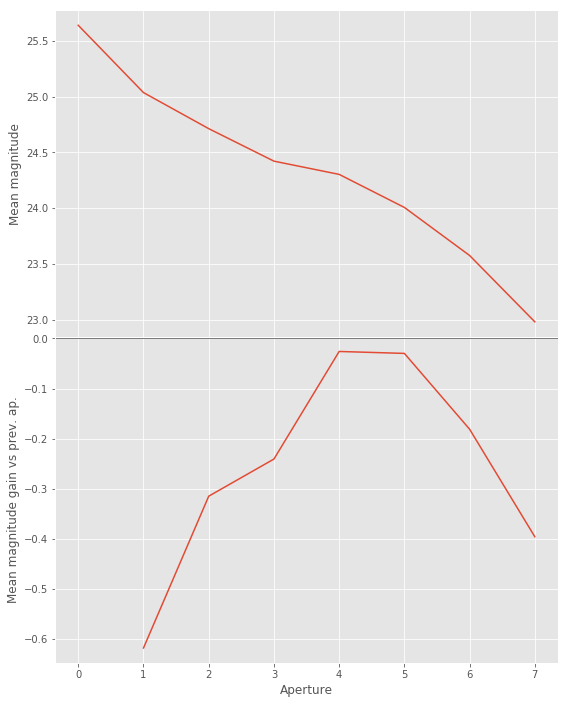

In [9]:
nb_plot_mag_ap_evol(magnitudes['g'], stellarities['g'], labels=apertures)

We will use aperture 5 as target.

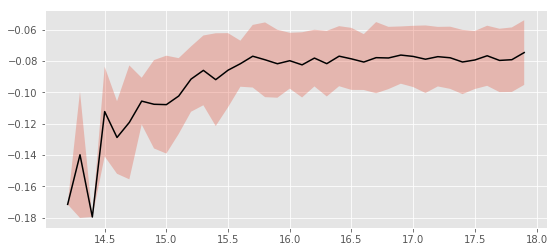

In [10]:
nb_plot_mag_vs_apcor(magnitudes['g'][4], 
                     magnitudes['g'][5], 
                     stellarities['g'])

We will use magnitudes between 16.0 and 19.0

In [11]:
# Aperture correction

mag_corr['g'], num, std = aperture_correction(
    magnitudes['g'][4], magnitudes['g'][5], 
    stellarities['g'],
    mag_min=16.0, mag_max=19.0)
print("Aperture correction for g band:")
print("Correction: {}".format(mag_corr['g']))
print("Number of source used: {}".format(num)) 
print("RMS: {}".format(std))


Aperture correction for g band:
Correction: -0.07828878191013189
Number of source used: 3747
RMS: 0.02005037338010651


### I.b - r band

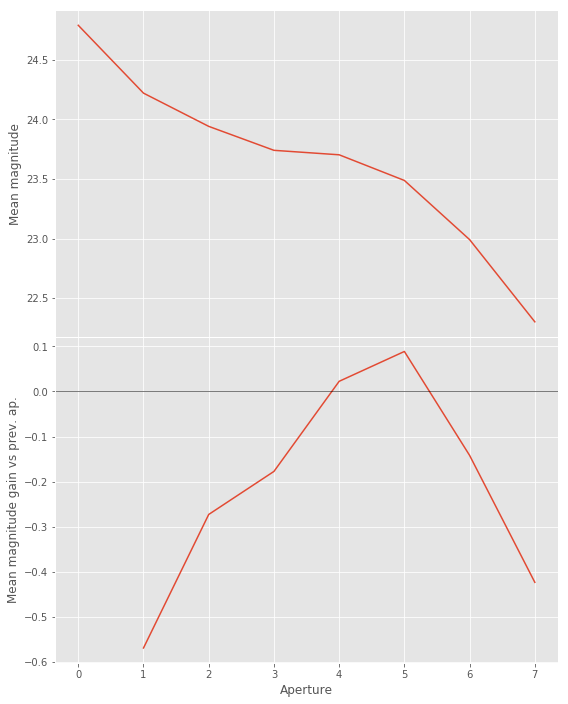

In [12]:
nb_plot_mag_ap_evol(magnitudes['r'], stellarities['r'], labels=apertures)

We will use aperture 5 as target.

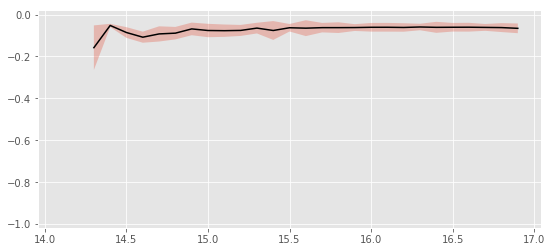

In [13]:
nb_plot_mag_vs_apcor(magnitudes['r'][4], 
                     magnitudes['r'][5], 
                     stellarities['r'])

We use magnitudes between 16.0 and 18.0.

In [14]:
# Aperture correction
mag_corr['r'], num, std = aperture_correction(
    magnitudes['r'][4], magnitudes['r'][5], 
    stellarities['r'],
    mag_min=16.0, mag_max=18.0)
print("Aperture correction for r band:")
print("Correction: {}".format(mag_corr['r']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for r band:
Correction: -0.0609926935865559
Number of source used: 2998
RMS: 0.02000000736251746


### I.d - i band

In [15]:
#nb_plot_mag_ap_evol(magnitudes['i'], stellarities['i'], labels=apertures)

In [16]:
#nb_plot_mag_vs_apcor(magnitudes['i'][4], 
#                     magnitudes['i'][4], 
#                     stellarities['i'])

In [17]:
# Aperture correction
#mag_corr['i'] = np.nan
#mag_corr['i'], num, std = aperture_correction(
#    magnitudes['i'][4], magnitudes['i'][5], 
#    stellarities['i'],
#    mag_min=16.0, mag_max=17.5)
#print("Aperture correction for i band:")
#print("Correction: {}".format(mag_corr['i']))
#print("Number of source used: {}".format(num))
#print("RMS: {}".format(std))

### I.e - z band

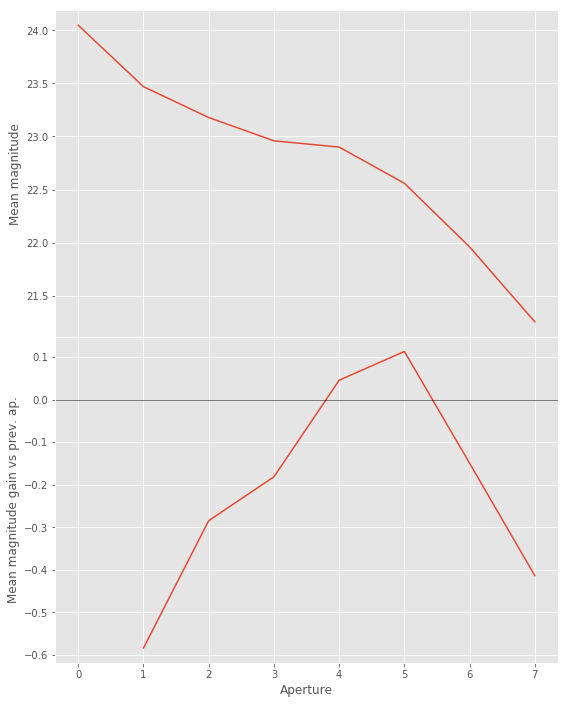

In [18]:
nb_plot_mag_ap_evol(magnitudes['z'], stellarities['z'], labels=apertures)

We will use aperture 4 as target.

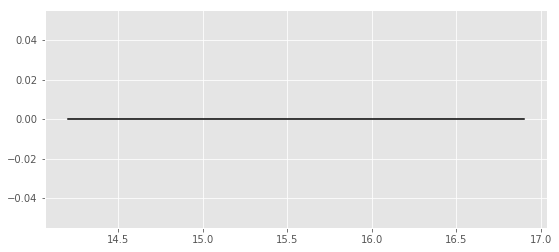

In [19]:
nb_plot_mag_vs_apcor(magnitudes['z'][4], 
                     magnitudes['z'][4], 
                     stellarities['z'])

We use magnitudes between 16.0 and 17.5.

In [20]:
# Aperture correction
#mag_corr['z'] = np.nan
mag_corr['z'], num, std = aperture_correction(
    magnitudes['z'][4], magnitudes['z'][5], 
    stellarities['z'],
    mag_min=16.0, mag_max=17.5)
print("Aperture correction for z band:")
print("Correction: {}".format(mag_corr['z']))
print("Number of source used: {}".format(num))
print("RMS: {}".format(std))

Aperture correction for z band:
Correction: -0.08840349726085606
Number of source used: 3336
RMS: 0.022340888963949663


### I.f - Y band

In [21]:
#nb_plot_mag_ap_evol(magnitudes['y'], stellarities['y'], labels=apertures)

In [22]:
#nb_plot_mag_vs_apcor(magnitudes['y'][4], 
#                     magnitudes['y'][4], 
#                     stellarities['y'])

In [23]:
# Aperture correction
#mag_corr['y'] = np.nan
#mag_corr['y'], num, std = aperture_correction(
#    magnitudes['y'][4], magnitudes['y'][5], 
#    stellarities['y'],
#    mag_min=16.0, mag_max=17.5)
#print("Aperture correction for y band:")
#print("Correction: {}".format(mag_corr['y']))
#print("Number of source used: {}".format(num))
#print("RMS: {}".format(std))


## II - Stellarity

Legacy Survey does not provide a 0 to 1 stellarity so we replace items flagged as PSF accpording to the following table:

\begin{equation*}
P(star) = \frac{ \prod_{i} P(star)_i }{ \prod_{i} P(star)_i + \prod_{i} P(galaxy)_i }
\end{equation*}

where $i$ is the band, and with using the same probabilities as UKDISS:

| HSC flag | UKIDSS flag | Meaning         | P(star) | P(galaxy) | P(noise) | P(saturated) |
|:--------:|:-----------:|:----------------|--------:|----------:|---------:|-------------:|
|          |      -9     | Saturated       |     0.0 |       0.0 |      5.0 |         95.0 |
|          |      -3     | Probable galaxy |    25.0 |      70.0 |      5.0 |          0.0 |
|          |      -2     | Probable star   |    70.0 |      25.0 |      5.0 |          0.0 |
|     0    |      -1     | Star            |    90.0 |       5.0 |      5.0 |          0.0 |
|          |      0      | Noise           |     5.0 |       5.0 |     90.0 |          0.0 |
|     1    |      +1     | Galaxy          |     5.0 |      90.0 |      5.0 |          0.0 |

In [24]:
stellarities['g'][np.isclose(stellarities['g'], 1.)] = 0.9
stellarities['g'][np.isclose(stellarities['g'], 0.)] = 0.05

## II - Column selection

In [25]:
imported_columns = OrderedDict({
        "objid": "decals_id",
        "brickid": "brickid",
        "ra": "decals_ra",
        "dec": "decals_dec",
        "decam_flux": "decam_flux_TEMP",
        "decam_flux_ivar": "decam_flux_ivar_TEMP",
        "decam_apflux": "decam_apflux_TEMP",
        "decam_apflux_ivar": "decam_apflux_ivar_TEMP",
       
    })


catalogue = Table.read("../../dmu0/dmu0_DECaLS/data/DECaLS_COSMOS.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]
    
catalogue["decals_id"] = 100000*catalogue["brickid"].astype(np.int64) + catalogue["decals_id"].astype(np.int64)
catalogue.remove_columns("brickid")

epoch = 2017

#catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,0], name="f_decam_u"))
catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,1], name="f_decam_g"))
catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,2], name="f_decam_r"))
#catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,3], name="f_decam_i"))
catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,4], name="f_decam_z"))
#catalogue.add_column(Column(catalogue["decam_flux_TEMP"][:,5], name="f_decam_y"))

#catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,0], name="ferr_decam_u"))
catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,1], name="ferr_decam_g"))
catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,2], name="ferr_decam_r"))
#catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,3], name="ferr_decam_i"))
catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,4], name="ferr_decam_z"))
#catalogue.add_column(Column(catalogue["decam_flux_ivar_TEMP"][:,5], name="ferr_decam_y"))

#For the aperture fluxes, there are 8 (0-7), we take 4 (2.0")
#DECam aperture fluxes on the co-added images in apertures of radius [0.5,0.75,1.0,1.5,2.0,3.5,5.0,7.0] arcsec in ugrizY
#catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,0], name="f_ap_decam_u")[:,4])
catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,1], name="f_ap_decam_g")[:,4])
catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,2], name="f_ap_decam_r")[:,4])
#catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,3], name="f_ap_decam_i")[:,4])
catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,4], name="f_ap_decam_z")[:,4])
#catalogue.add_column(Column(catalogue["decam_apflux_TEMP"][:,5], name="f_ap_decam_y")[:,4])

#catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,0], name="ferr_ap_decam_u")[:,4])
catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,1], name="ferr_ap_decam_g")[:,4])
catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,2], name="ferr_ap_decam_r")[:,4])
#catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,3], name="ferr_ap_decam_i")[:,4])
catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,4], name="ferr_ap_decam_z")[:,4])
#catalogue.add_column(Column(catalogue["decam_apflux_ivar_TEMP"][:,5], name="ferr_ap_decam_y")[:,4])

catalogue.remove_columns(["decam_flux_TEMP", 
                          "decam_flux_ivar_TEMP", 
                          "decam_apflux_TEMP", 
                          "decam_apflux_ivar_TEMP"])

# Clean table metadata
catalogue.meta = None

In [26]:
flux_to_mag_vect = np.vectorize(flux_to_mag)


# Adding magnitude and band-flag columns
for col in catalogue.colnames:
    catalogue[col].unit = None
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        #Replace 0 flux with NaN and 
        mask = (catalogue[col] <= 0.0) | (catalogue[errcol] <= 0.0)
        catalogue[col][mask] = np.nan
        
        #Replace 1/sigma^2 with sigma 

        catalogue[errcol][mask] = np.nan
        catalogue[errcol] = np.sqrt(1/np.array(catalogue[errcol]))
        #catalogue[errcol][catalogue[errcol] == None] = np.nan
        
        #Replace nanomaggies with uJy
        #a nanomaggy is approximately 3.631×10-6 Jy - http://www.sdss3.org/dr8/algorithms/magnitudes.php#nmgy
        catalogue[col] = catalogue[col]  * 3.631        
        catalogue[errcol] = catalogue[errcol]  * 3.631
        
        #Compute magnitudes and errors in magnitudes. This function expects Jy so must multiply uJy by 1.e-6
        mag, error = flux_to_mag(np.array(catalogue[col])* 1.e-6, np.array(catalogue[errcol])* 1.e-6)
        
        if 'ap' in col:
            mag += mag_corr[col[-1]]
            catalogue[col],catalogue[errcol] = mag_to_flux(mag,error) 
            catalogue[col] *= 1.e6
            catalogue[errcol] *= 1.e6
        
        catalogue.add_column(Column(mag, name="m{}".format(col[1:])))
        catalogue.add_column(Column(error, name="m{}".format(errcol[1:])))
        
        # Band-flag column
        if 'ap' not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
#remove units from table
for col in catalogue.colnames:
    catalogue[col].unit = None
    
catalogue.add_column(Column(data=stellarities['g'], name="decals_stellarity")) #Stelarites computed earlier

In [27]:
catalogue[:10].show_in_notebook()

idx,decals_id,decals_ra,decals_dec,f_decam_g,f_decam_r,f_decam_z,ferr_decam_g,ferr_decam_r,ferr_decam_z,f_ap_decam_g,f_ap_decam_r,f_ap_decam_z,ferr_ap_decam_g,ferr_ap_decam_r,ferr_ap_decam_z,m_decam_g,merr_decam_g,flag_decam_g,m_decam_r,merr_decam_r,flag_decam_r,m_decam_z,merr_decam_z,flag_decam_z,m_ap_decam_g,merr_ap_decam_g,m_ap_decam_r,merr_ap_decam_r,m_ap_decam_z,merr_ap_decam_z,decals_stellarity
0,34248500034,149.46994153281145,1.876617386837168,6.7018485,9.862116,11.822996,0.13282356,0.21459636,0.26239622,5.756361,10.241882,12.104498,0.22676235,0.3918306,0.39978924,21.83451,0.021518143,False,21.415077,0.023625256,False,21.218185,0.024096519,False,21.99963,0.042770788,21.37405,0.04153774,21.192633,0.035859868,0.9
1,34248500037,149.471957838006,1.8756285168633098,1.6758254,2.3754823,5.4691997,0.15236226,0.25672507,0.3251451,1.2645038,2.5676417,6.2709002,0.22658041,0.39182907,0.41533053,23.339432,0.09871268,False,22.960625,0.11733856,False,22.055199,0.06454725,False,23.645199,0.19454789,22.876163,0.16568628,21.906675,0.07190983,0.05
2,34248500043,149.36158437074488,1.8755266970830629,1.8071287,3.8210576,11.2047,0.2771531,0.46196935,0.44892186,3.4008882,3.8578956,11.233515,0.36429885,0.6087538,0.57117885,23.25753,0.16651562,False,22.444542,0.1312665,False,21.276497,0.043500558,False,22.571018,0.116302684,22.434124,0.17132296,21.27371,0.055205304,0.05
3,34248500050,149.417082867936,1.8760381940327204,0.44948792,4.330613,32.99592,0.40594316,0.71567,0.7795189,0.15451209,2.292889,13.763537,0.22695756,0.4238481,0.3997518,24.768211,0.980554,False,22.308632,0.17942697,False,20.103851,0.0256502,False,25.927593,1.594801,22.999043,0.2007019,21.053175,0.03153441,0.05
4,34248500051,149.41589114643537,1.875192737365069,0.44186926,1.5127891,4.678369,0.14894342,0.258228,0.316723,0.38860813,3.0038009,5.4147534,0.22632965,0.42910415,0.4021706,24.786766,0.36597538,False,23.450554,0.18533151,False,22.22477,0.07350373,False,24.92622,0.6323447,22.705822,0.15510146,22.066053,0.08064101,0.05
5,34248500089,149.35698122721604,1.8752938692202454,1.7689438,6.202725,32.3264,0.28357014,0.491076,0.79215324,0.980236,3.7782154,19.372776,0.22856806,0.3973888,0.57360864,23.280716,0.17404869,False,21.918541,0.08595882,False,20.126106,0.02660579,False,23.921673,0.25316823,22.456783,0.11419661,20.68202,0.03214757,0.05
6,34248500093,149.39090264741455,1.8754296038280185,nan,nan,3.3775237,nan,nan,0.27953082,nan,nan,2.1097345,nan,nan,0.4282928,nan,nan,False,nan,nan,False,22.578506,0.08985776,False,nan,nan,nan,nan,23.08943,0.22041303,0.9
7,34248500113,149.27831823191732,1.8756407397751198,0.75472903,1.4737195,3.3508303,0.11424584,0.1891813,0.27362815,1.7584869,1.6681522,3.1000776,0.22856702,0.39738786,0.42644647,24.205528,0.16435148,False,23.478966,0.13937588,False,22.58712,0.08866099,False,23.287151,0.14112331,23.34441,0.2586445,22.671568,0.1493538,0.9
8,34248500115,149.27910051978415,1.8751681221402652,0.380443,0.6468196,0.91139776,0.1134444,0.18666059,0.273685,0.55454105,0.39877424,1.2440633,0.22856669,0.39738953,0.42793563,24.94928,0.32375598,False,24.37304,0.31332403,False,24.000732,0.32603735,False,24.540165,0.44751084,24.898182,1.081966,23.662893,0.3734739,0.9
9,34248500129,149.4877014153283,1.8753260721554859,1.2005203,1.4421924,2.3237376,0.10720691,0.1656023,0.25691465,0.91581595,1.895883,2.7906349,0.20501353,0.33093408,0.40774962,23.701576,0.09695665,False,23.502441,0.12467158,False,22.984535,0.12004002,False,23.99548,0.2430517,23.205471,0.18951967,22.785742,0.15864079,0.9


## III - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [28]:
SORT_COLS = [#'merr_ap_decam_u',
             'merr_ap_decam_g',
             'merr_ap_decam_r',
             #'merr_ap_decam_i',
             'merr_ap_decam_z',
             #'merr_ap_decam_y'
]
FLAG_NAME = 'decals_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(
    catalogue, RA_COL, DEC_COL, 
    sort_col= SORT_COLS,
    flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 376709 sources.
The cleaned catalogue has 376653 sources (56 removed).
The cleaned catalogue has 56 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [29]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_COSMOS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


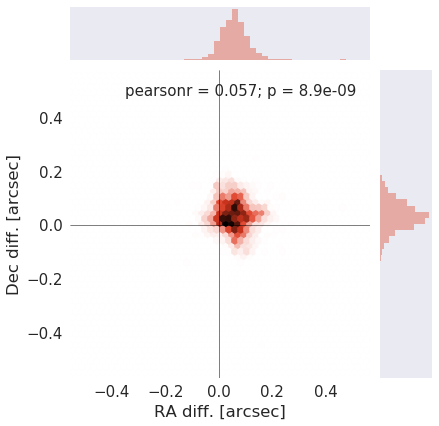

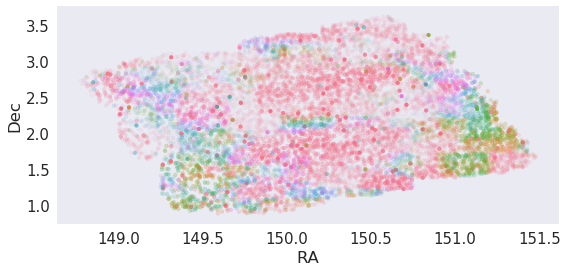

In [30]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [31]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.0579814082698249 arcsec
Dec correction: -0.03379117265440712 arcsec


In [32]:
catalogue[RA_COL] = catalogue[RA_COL] +  delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL] +  delta_dec.to(u.deg)
catalogue[RA_COL].unit = u.deg
catalogue[DEC_COL].unit = u.deg

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


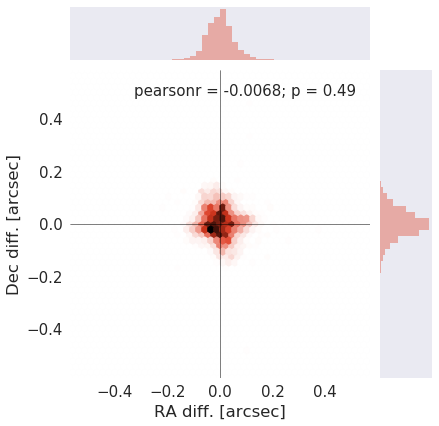

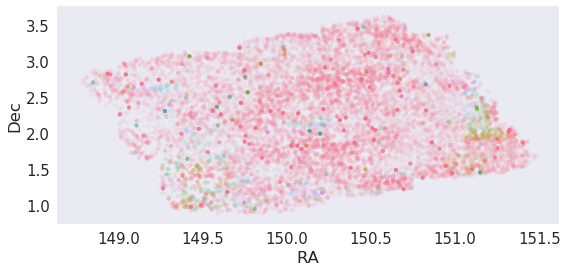

In [33]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [34]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [35]:
GAIA_FLAG_NAME = "decals_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

10677 sources flagged.


# V - Saving to disk

In [36]:
catalogue.write("{}/DECaLS.fits".format(OUT_DIR), overwrite=True)